<a href="https://colab.research.google.com/github/salwaadalla/wind-turbine-predictive-maintenance-/blob/main/REWIND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [ ]:
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Loading the dataset

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Train.csv.csv')

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Test.csv.csv')

## Data Overview

- Observations
- Sanity checks

In [ ]:
df.shape

(20000, 41)

* There are 5000 rows in the data ans 41 columns in the train data.

In [ ]:
df_test.shape

(5000, 41)

* There are 5000 rows and 41 columns in the test data.

In [ ]:
data = df.copy()

In [ ]:
data_test = df_test.copy()

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

* All the data is of the same type.

In [ ]:
data.duplicated().sum()

0

In [ ]:
data_test.duplicated().sum()

0

* There is no duplicates in the test or train data.

In [ ]:
data.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [ ]:
data_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

* There are two columns in the train data and test data (V1 and V2) with missing values.

In [ ]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000,4994.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,-0.278,0.398,2.552,-0.049,-0.080,-1.042,-0.908,-0.575,0.030,0.019,-2.009,1.576,1.622,-0.921,-2.452,-3.019,-0.104,1.196,1.210,0.138,-3.664,0.962,-0.422,1.089,0.061,1.847,-0.552,-0.868,-1.096,-0.119,0.469,0.233,-0.080,-0.393,2.211,1.595,0.023,-0.406,0.939,-0.932,0.056
std,3.466,3.140,3.327,3.414,2.111,2.005,1.769,3.332,2.174,2.145,3.112,2.907,2.883,1.803,3.387,4.264,3.337,2.586,3.385,3.657,3.578,1.640,4.057,3.968,2.010,3.400,4.403,1.926,2.655,3.023,3.446,5.586,3.539,3.166,2.948,3.775,1.785,3.969,1.717,2.978,0.231
min,-12.382,-10.716,-9.238,-14.682,-7.712,-8.924,-8.124,-12.253,-6.785,-8.171,-13.152,-8.164,-11.548,-7.814,-15.286,-20.986,-13.418,-12.214,-14.170,-13.720,-16.341,-6.740,-14.422,-12.316,-6.770,-11.414,-13.177,-7.933,-9.988,-12.438,-11.263,-17.244,-14.904,-14.700,-12.261,-12.736,-5.079,-15.335,-5.451,-10.076,0.000
25%,-2.744,-1.649,0.315,-2.293,-1.615,-2.369,-2.054,-2.642,-1.456,-1.353,-4.050,-0.450,-0.126,-2.111,-4.479,-5.648,-2.228,-0.409,-1.026,-2.325,-5.944,-0.048,-3.163,-1.623,-1.298,-0.242,-3.663,-2.160,-2.861,-1.997,-1.822,-3.556,-2.348,-2.010,0.322,-0.866,-1.241,-2.984,-0.208,-2.987,0.000
50%,-0.765,0.427,2.260,-0.146,-0.132,-1.049,-0.940,-0.358,-0.080,0.166,-2.043,1.488,1.719,-0.896,-2.417,-2.774,0.047,0.881,1.296,0.193,-3.663,0.986,-0.279,0.913,0.077,1.917,-0.872,-0.931,-1.341,0.112,0.486,-0.077,-0.160,-0.172,2.112,1.703,-0.110,-0.381,0.959,-1.003,0.000
75%,1.831,2.444,4.587,2.166,1.341,0.308,0.212,1.713,1.450,1.511,0.044,3.563,3.465,0.272,-0.433,-0.178,2.112,2.604,3.526,2.540,-1.330,2.029,2.426,3.537,1.428,4.156,2.247,0.421,0.522,1.946,2.779,3.752,2.099,1.465,4.032,4.104,1.238,2.288,2.131,1.080,0.000
max,13.504,14.079,15.315,12.140,7.673,5.068,7.616,10.415,8.851,6.599,9.956,12.984,12.620,5.734,11.673,13.976,19.777,13.642,12.428,13.871,11.047,7.505,13.181,17.806,6.557,17.528,17.290,7.416,14.039,10.315,12.559,26.539,13.324,12.146,13.489,17.116,6.810,13.065,7.182,8.698,1.000


- Values of all the variables lies between -25 and 25
- Looking at the values of 75th percentile and maximum, we can see there are outliers in many variables like V1, V2 and many more.

## Exploratory Data Analysis

### Plotting histograms and boxplots for all the variables

In [ ]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )

### Plotting all the features at one go

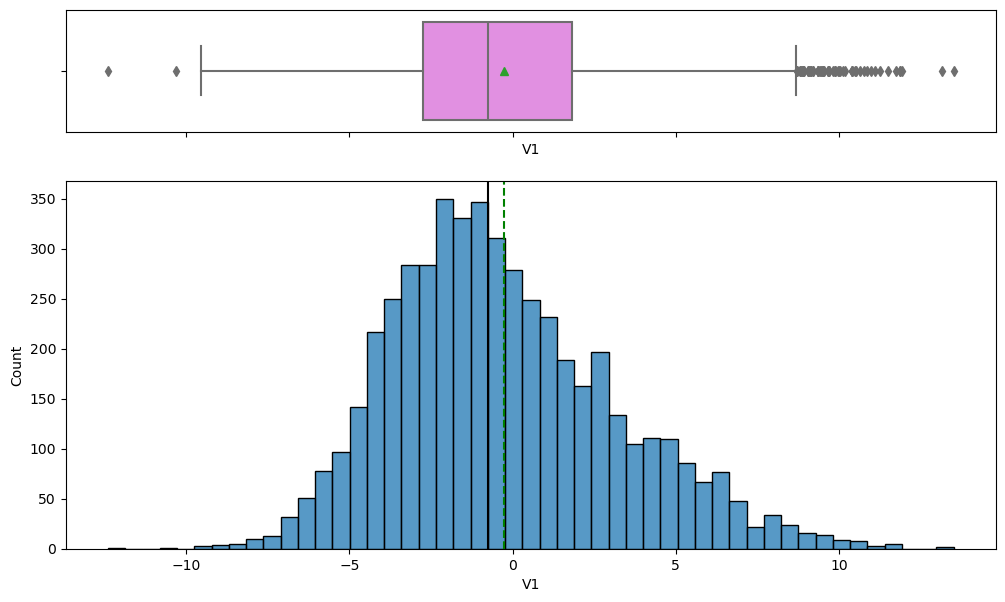

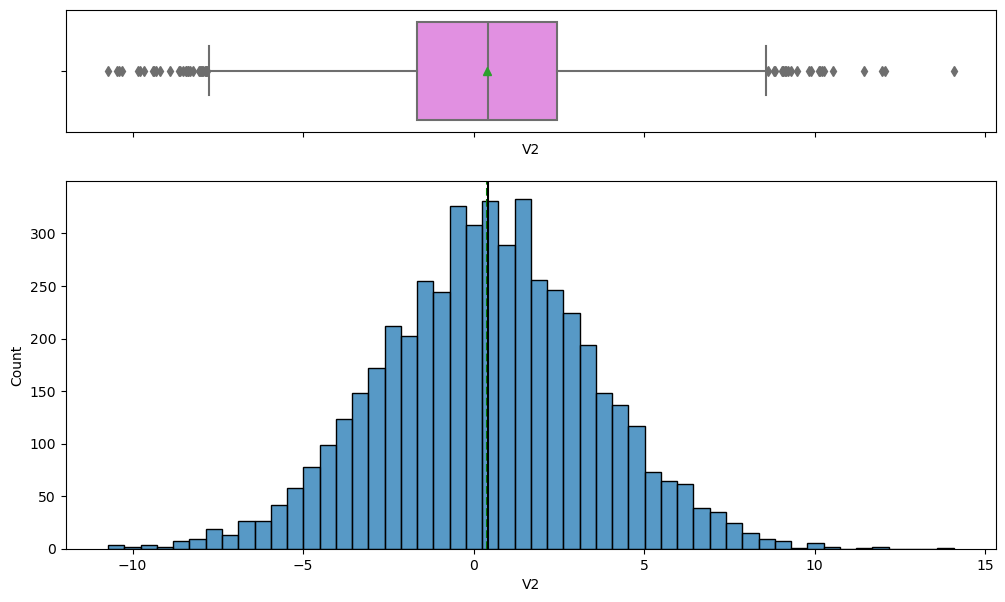

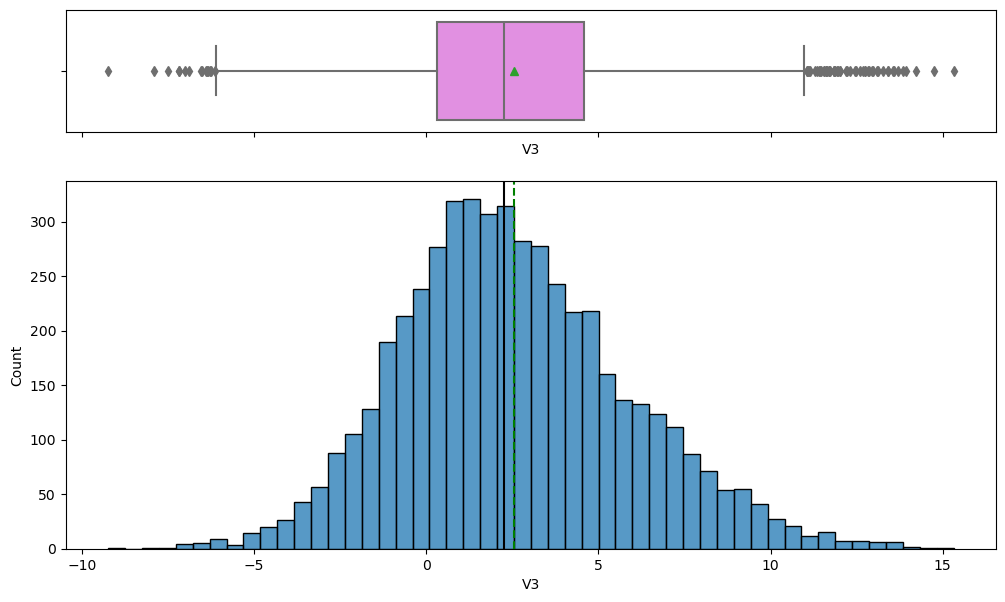

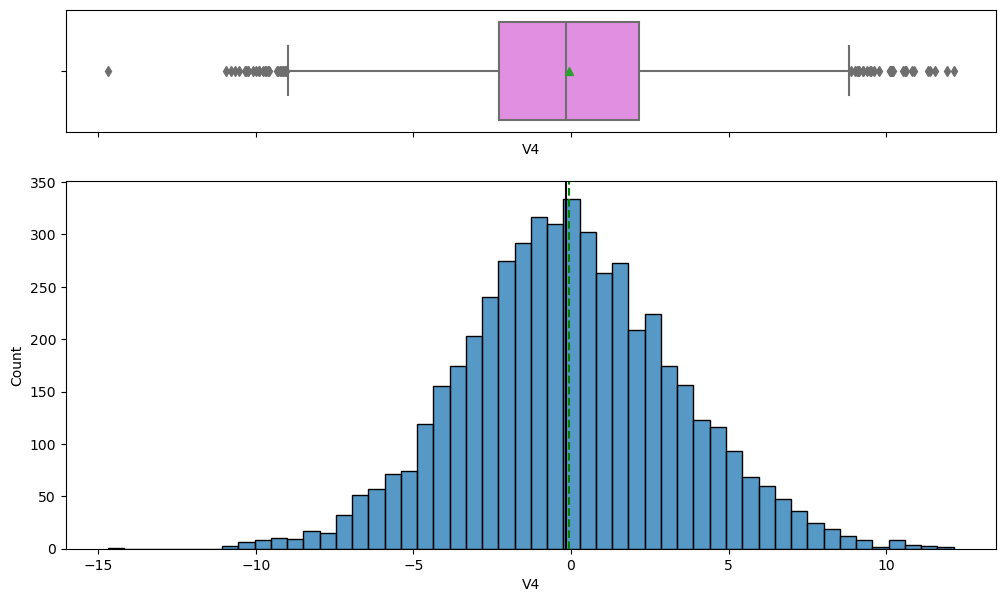

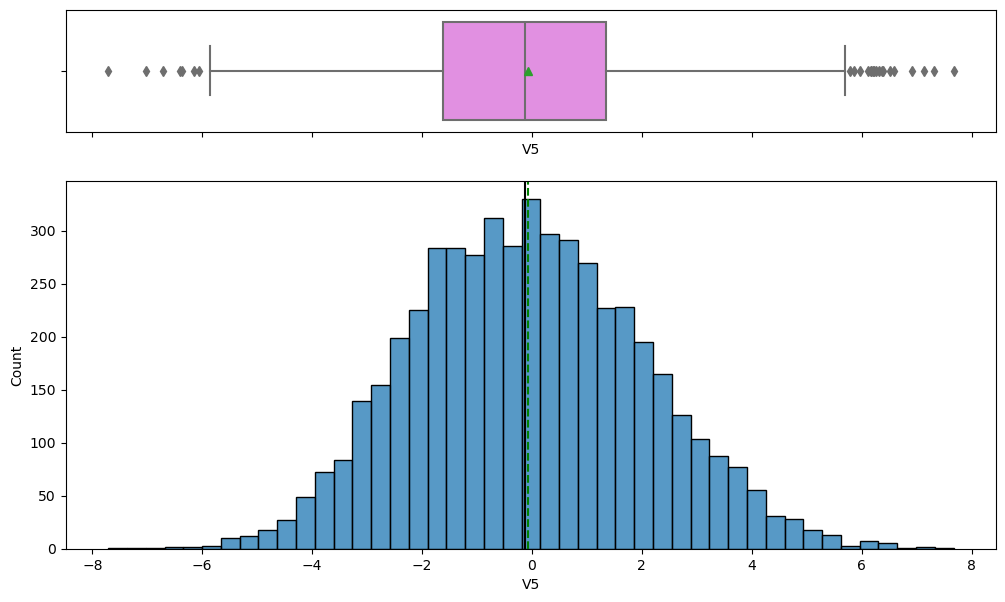

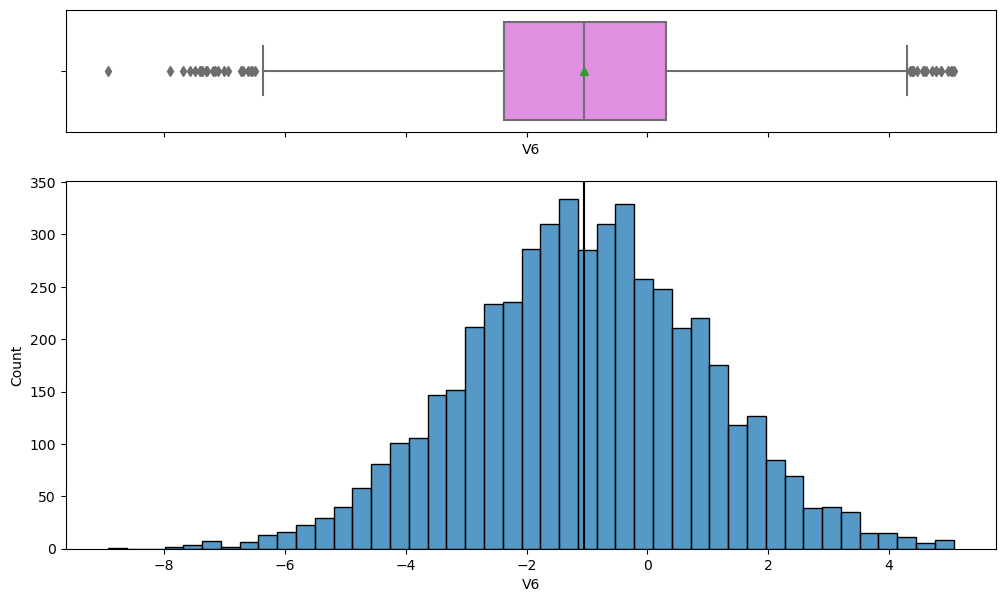

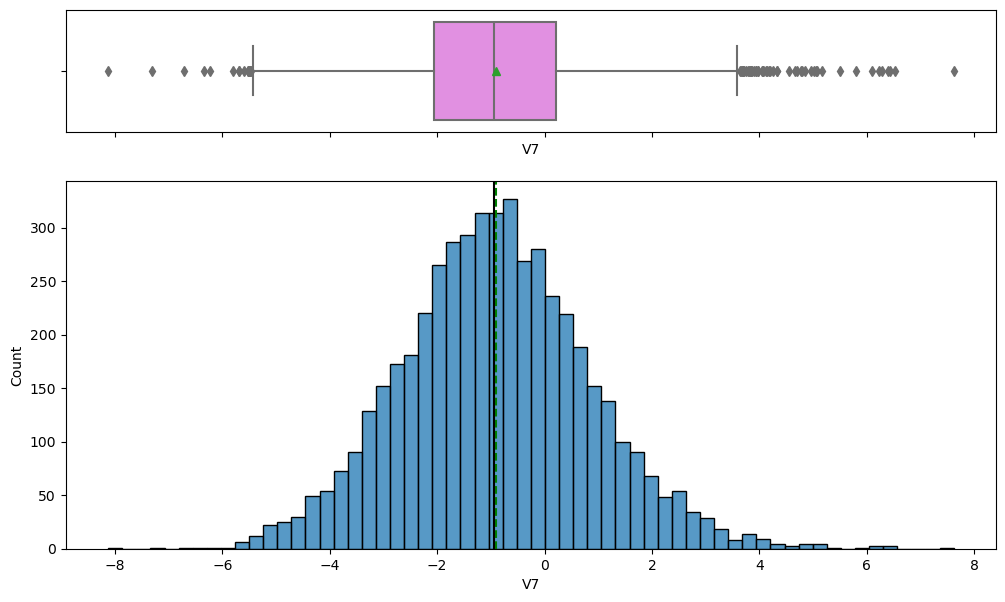

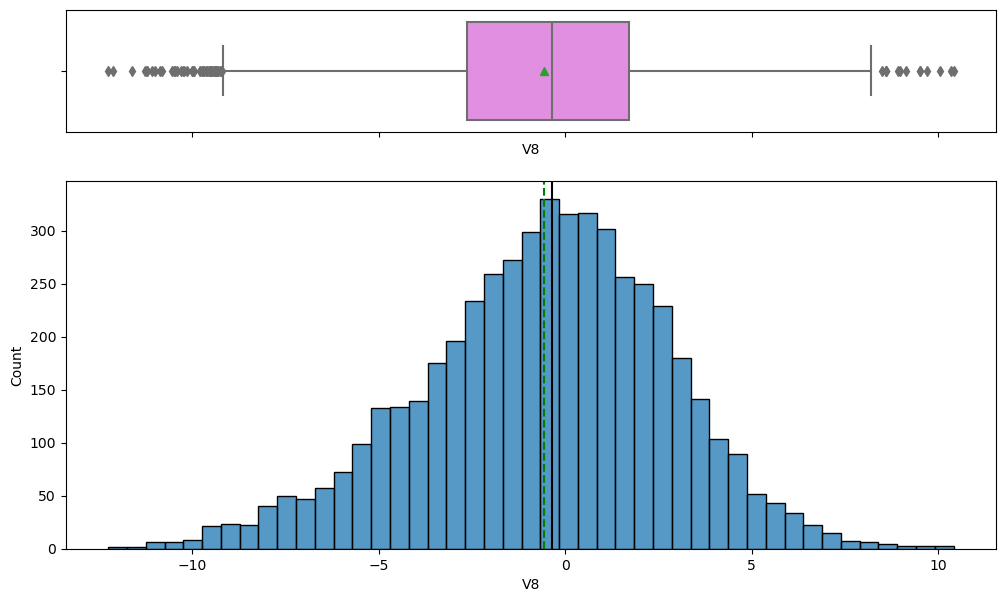

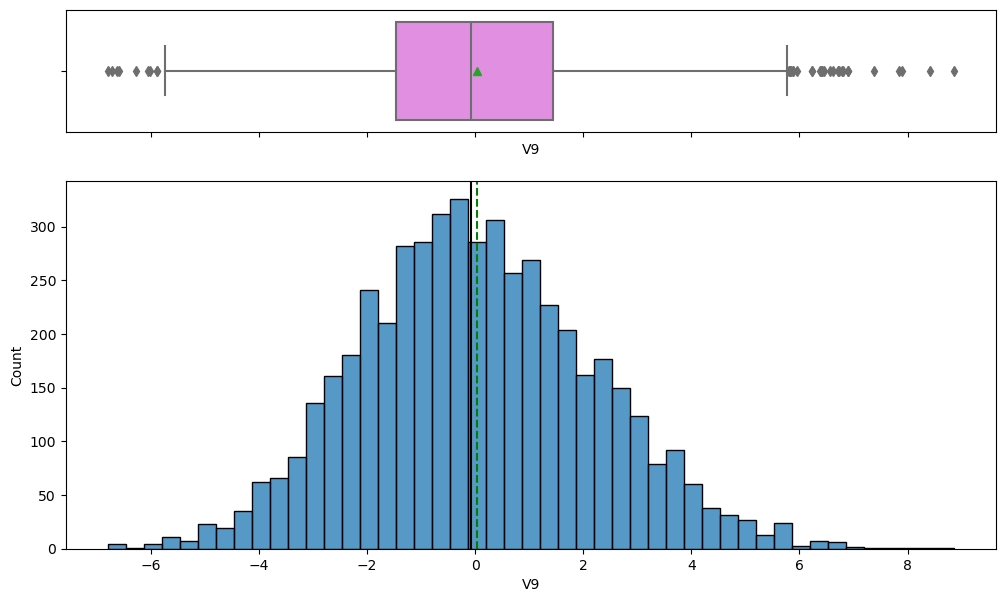

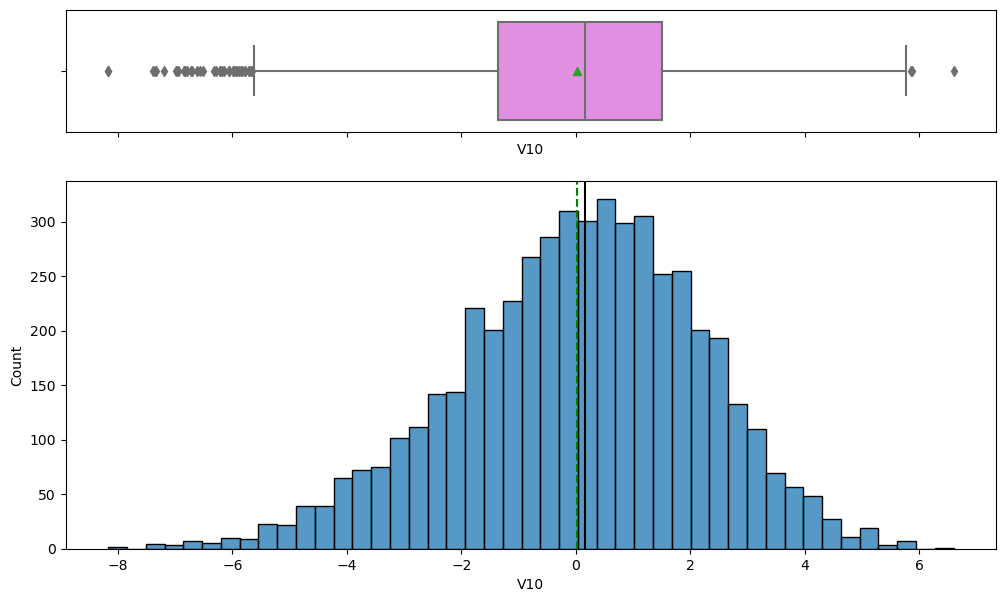

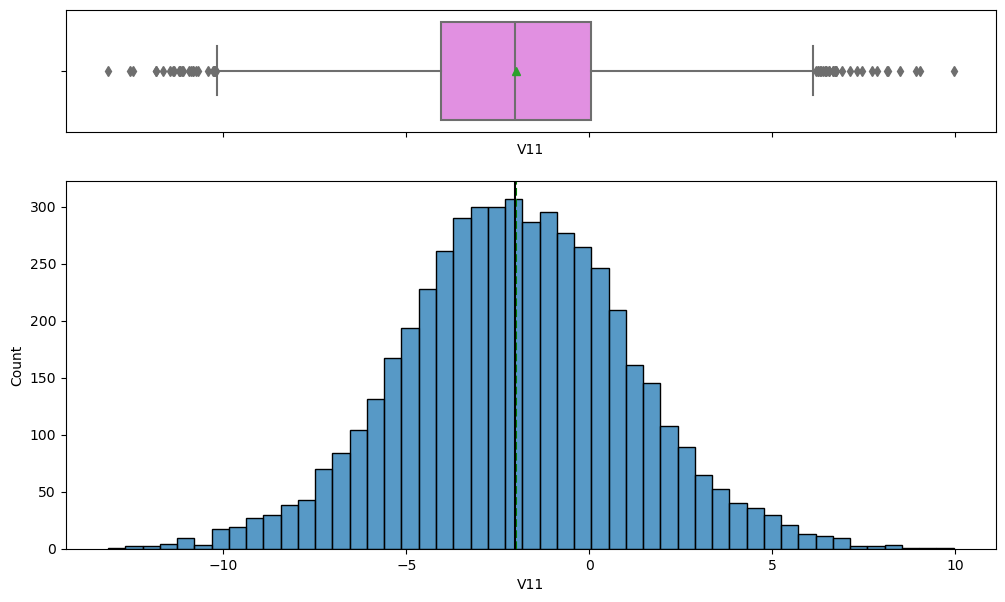

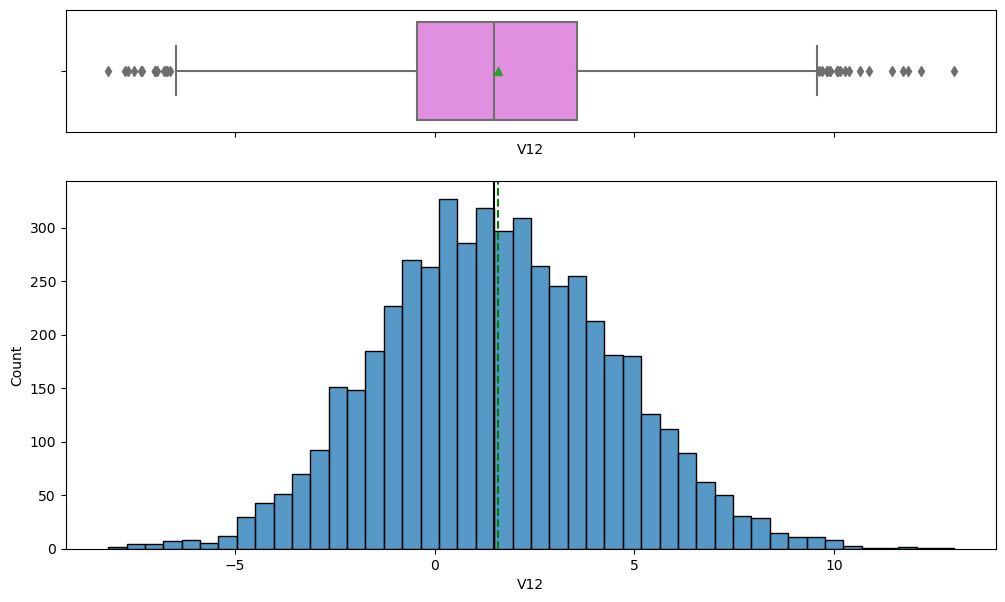

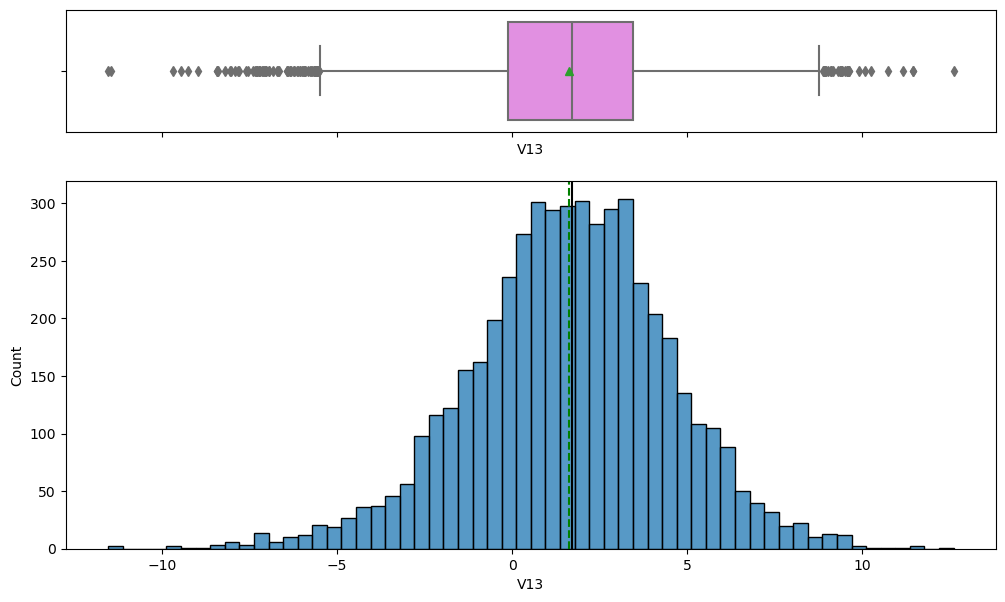

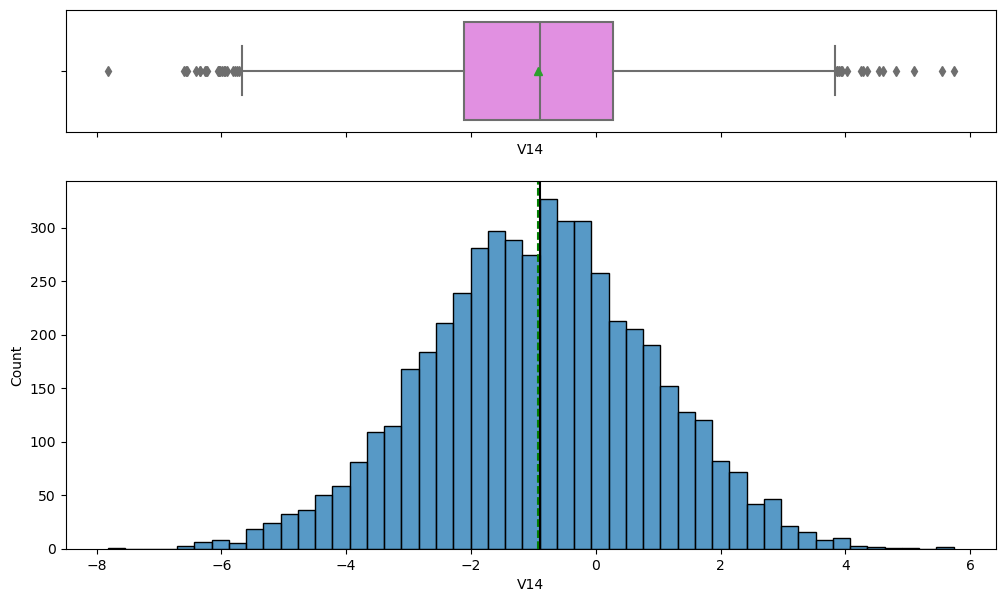

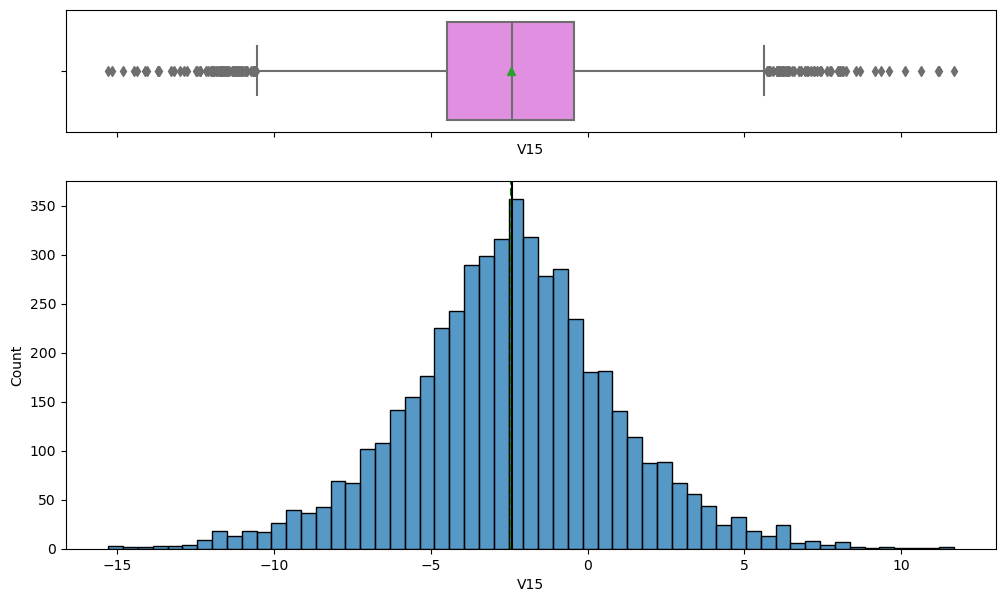

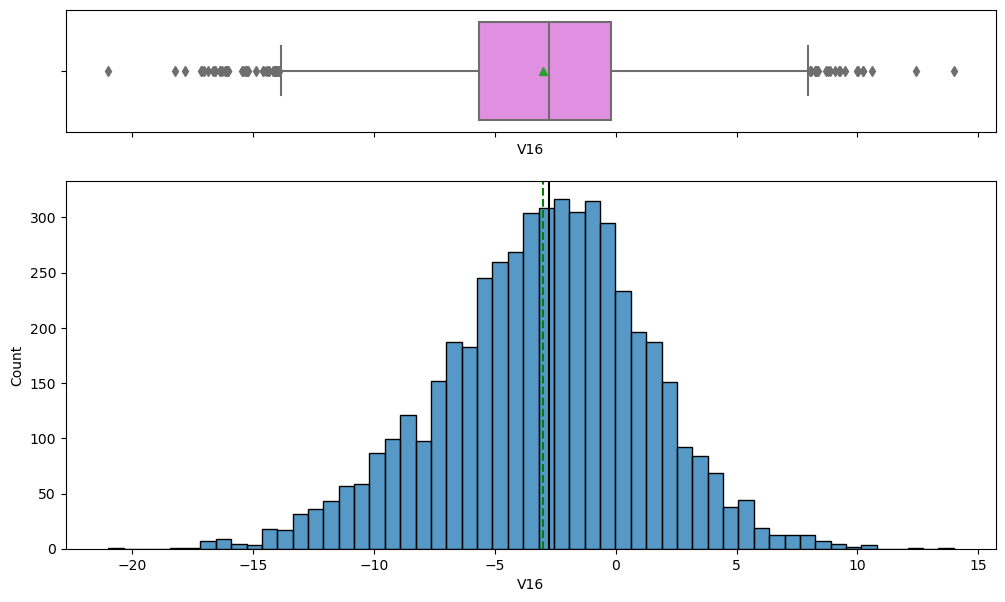

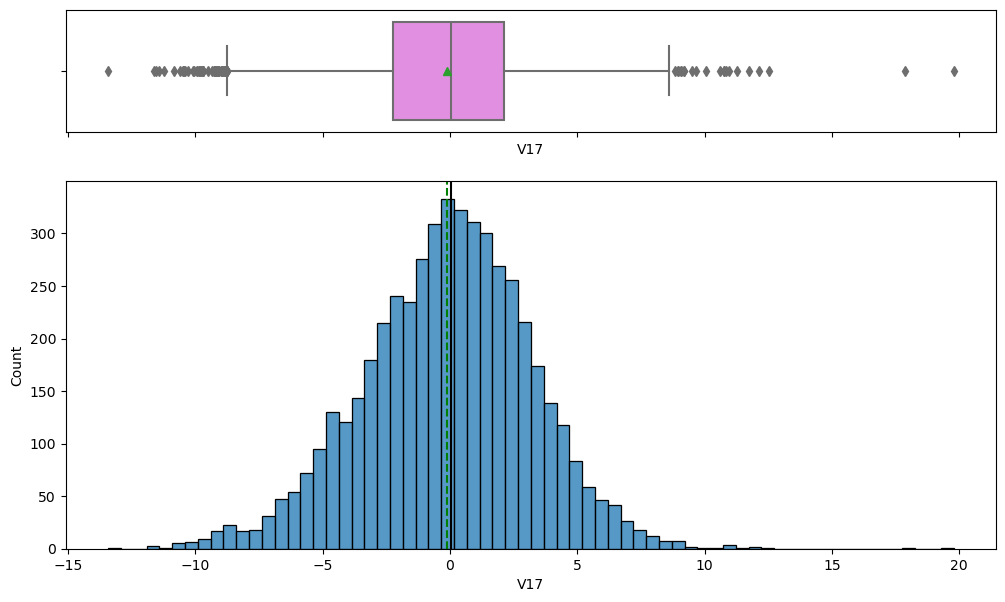

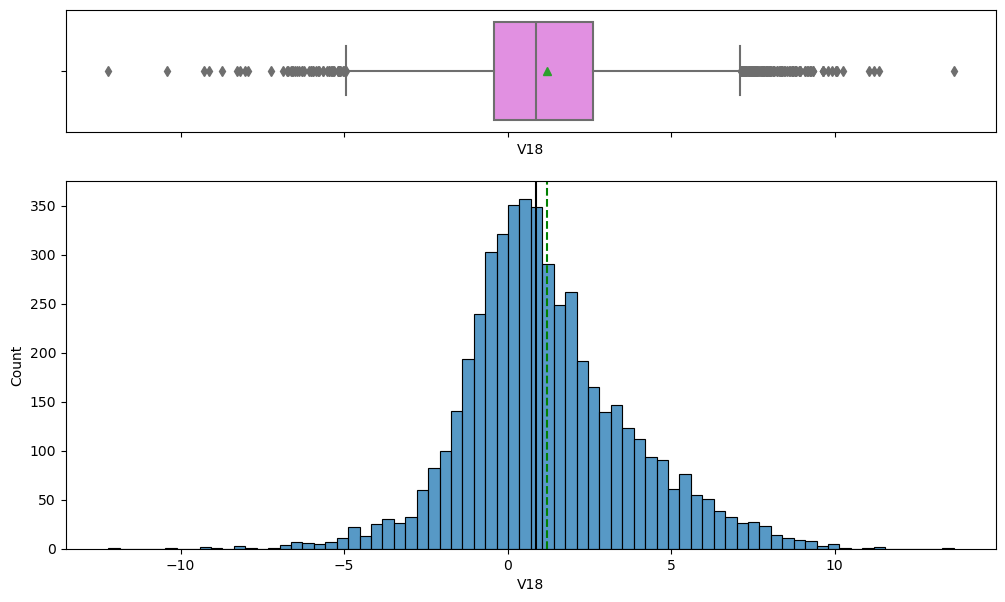

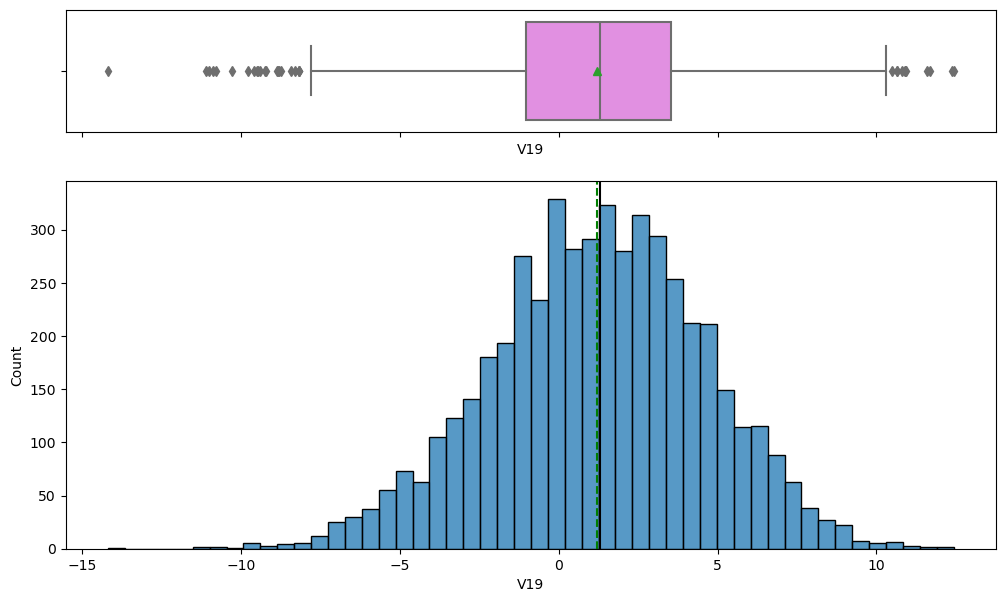

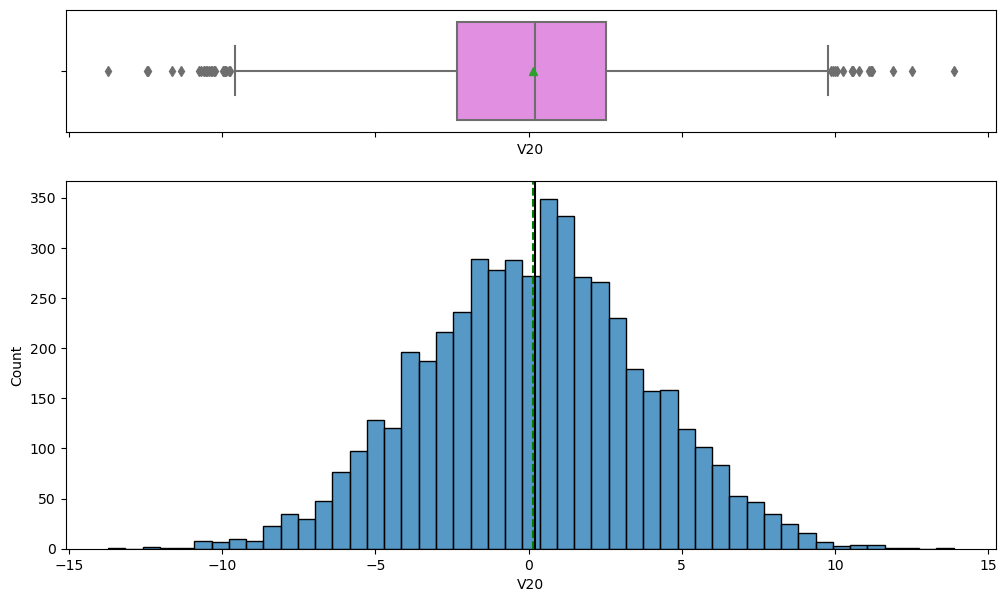

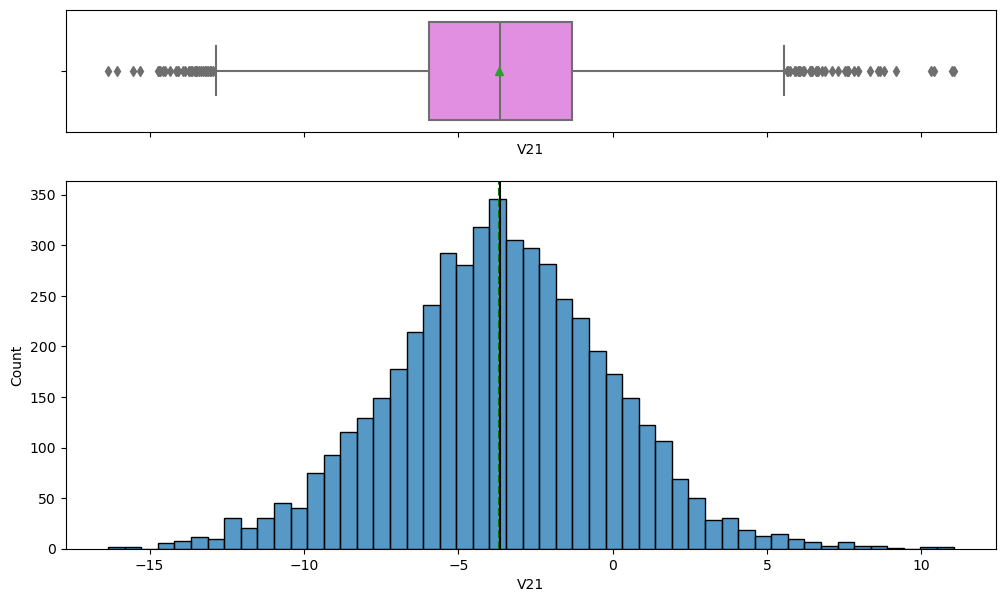

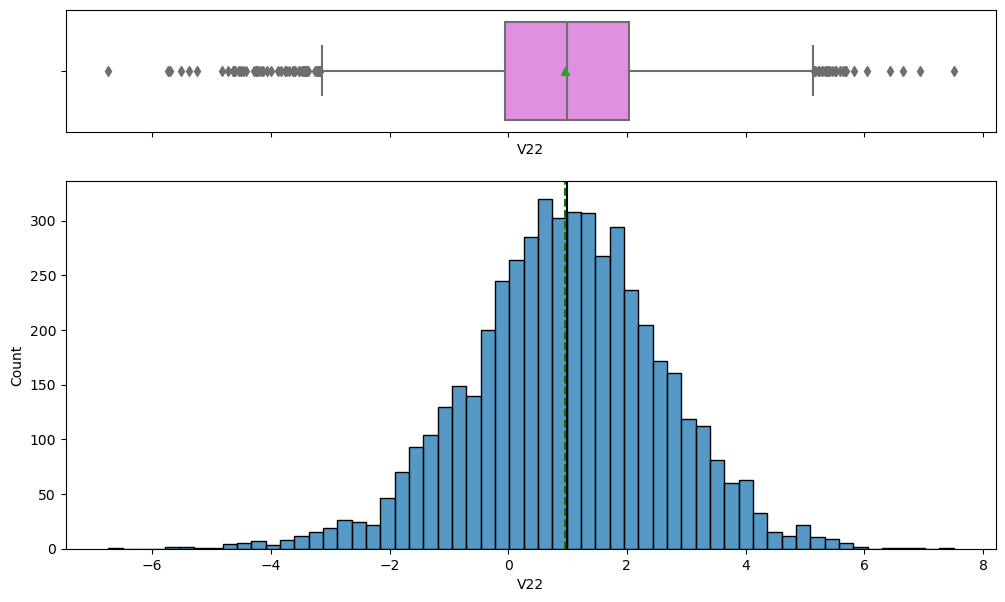

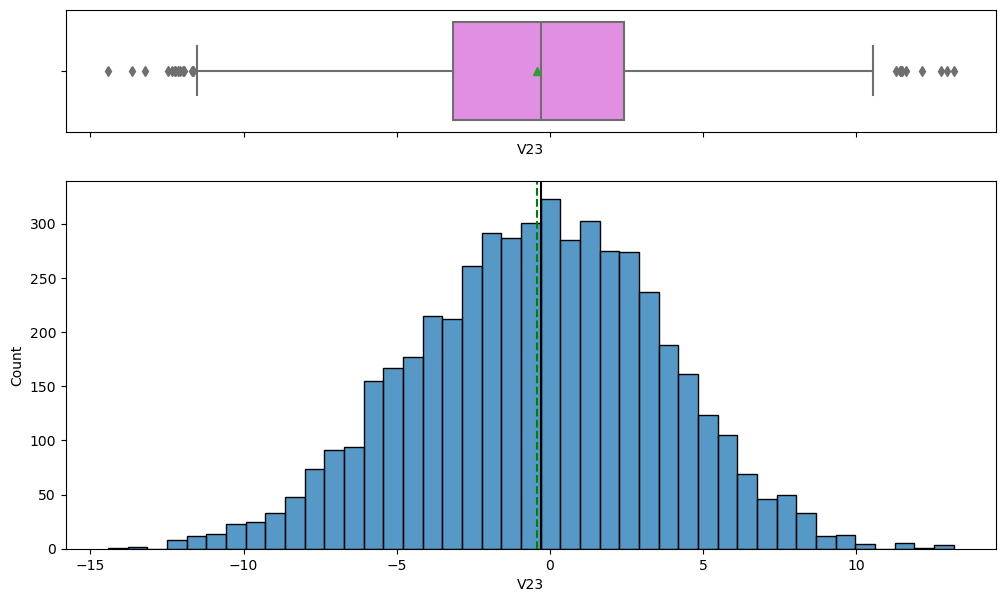

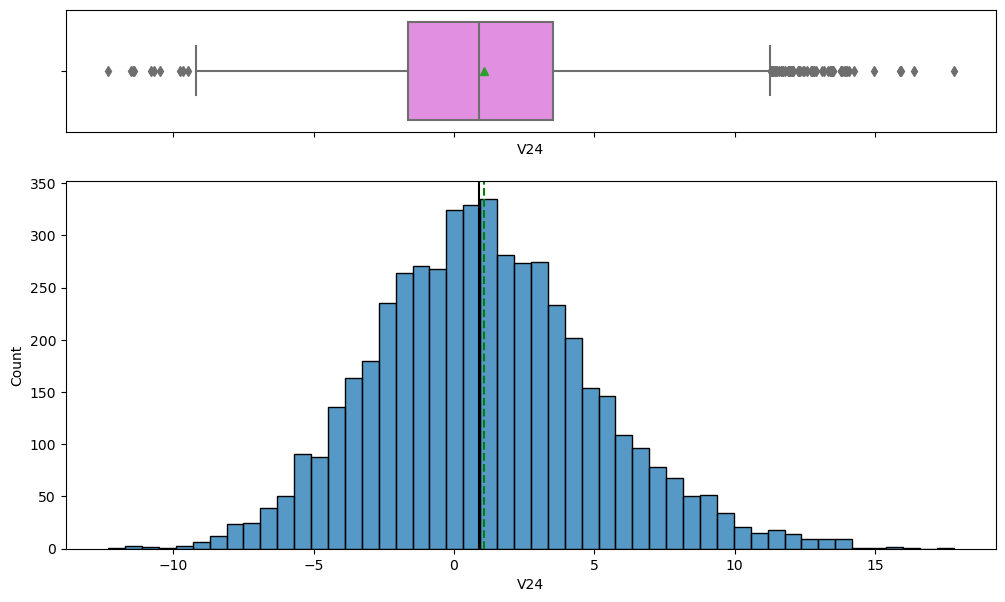

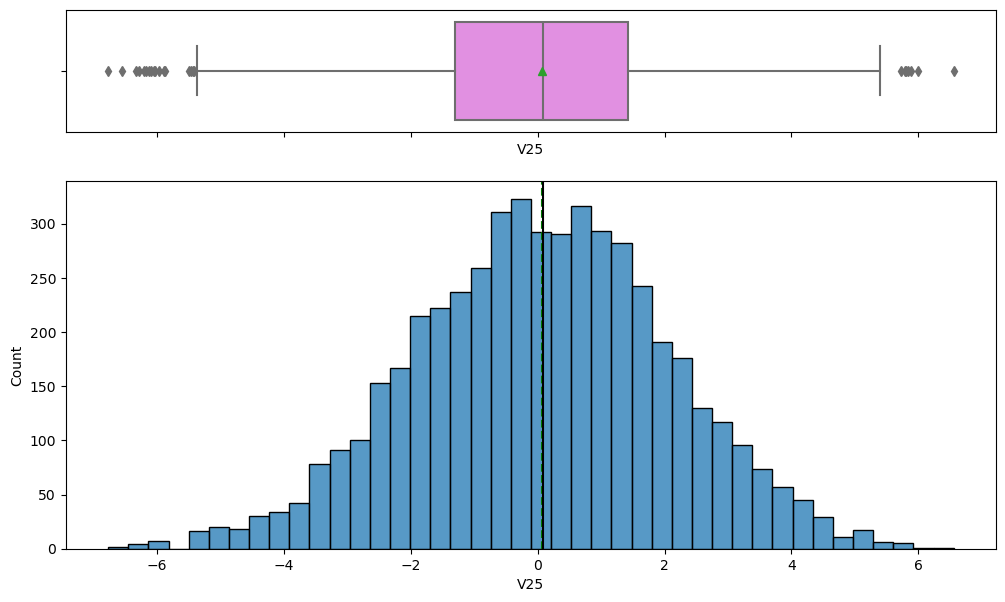

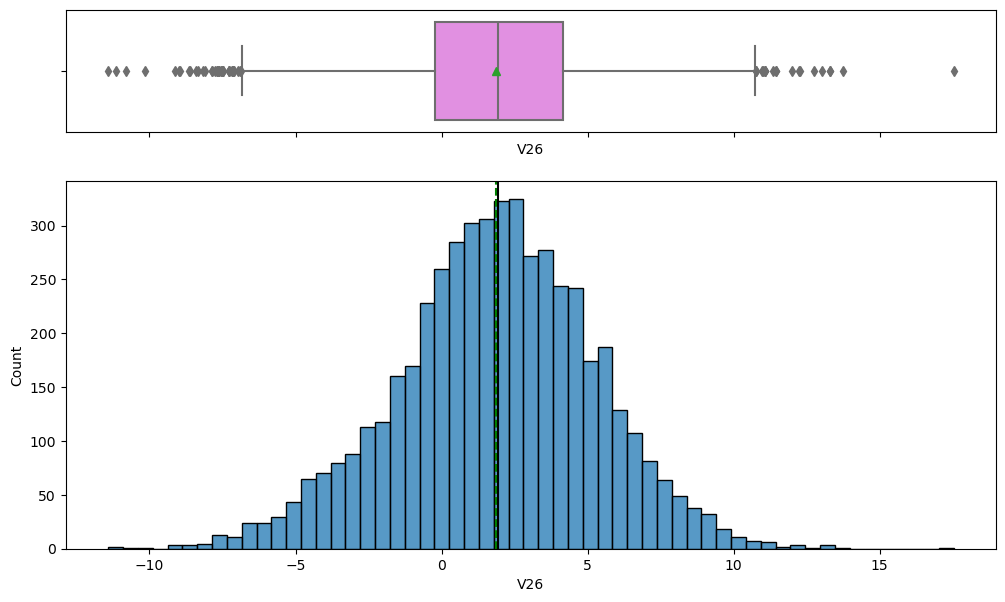

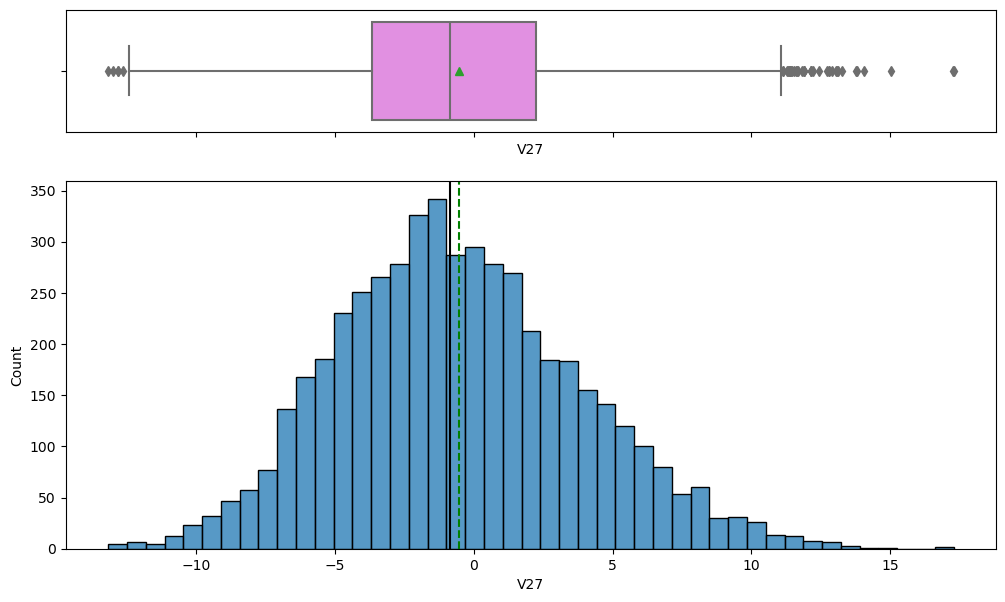

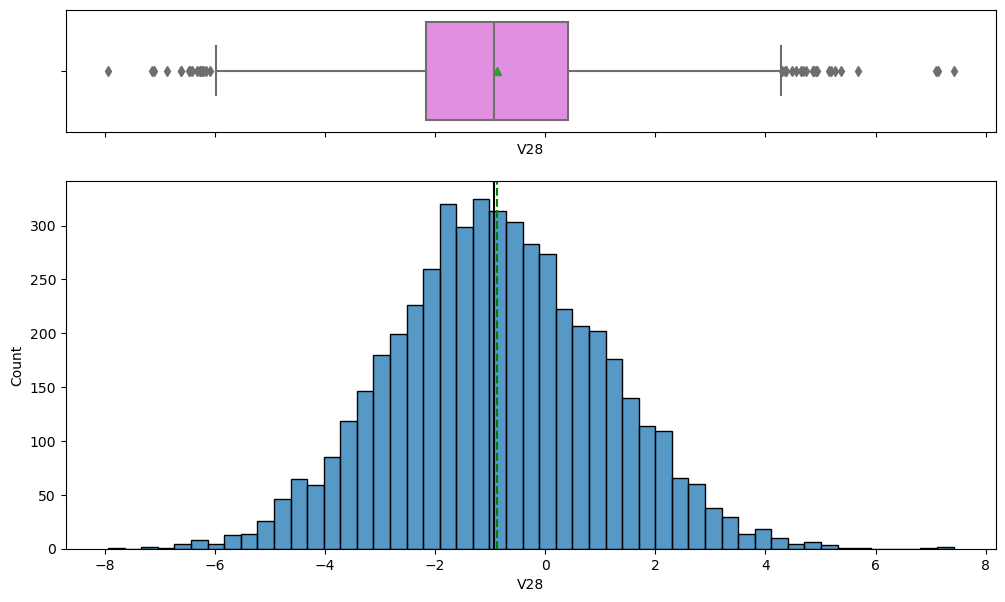

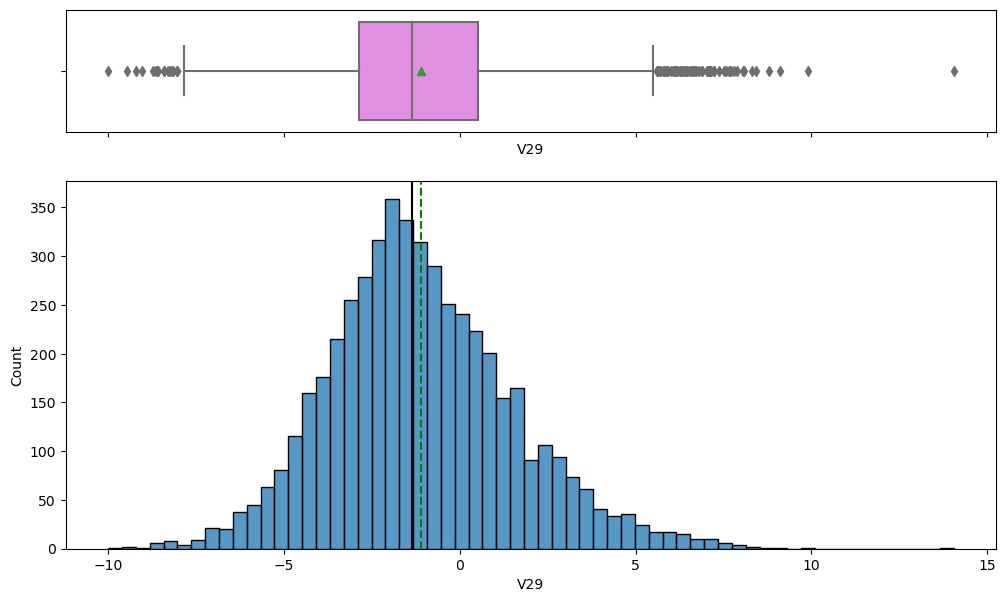

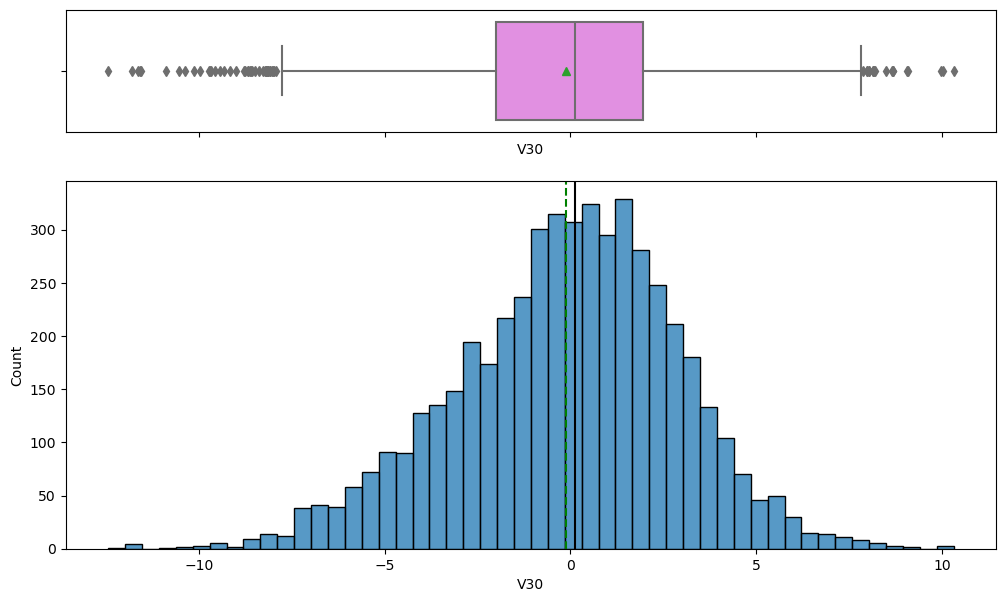

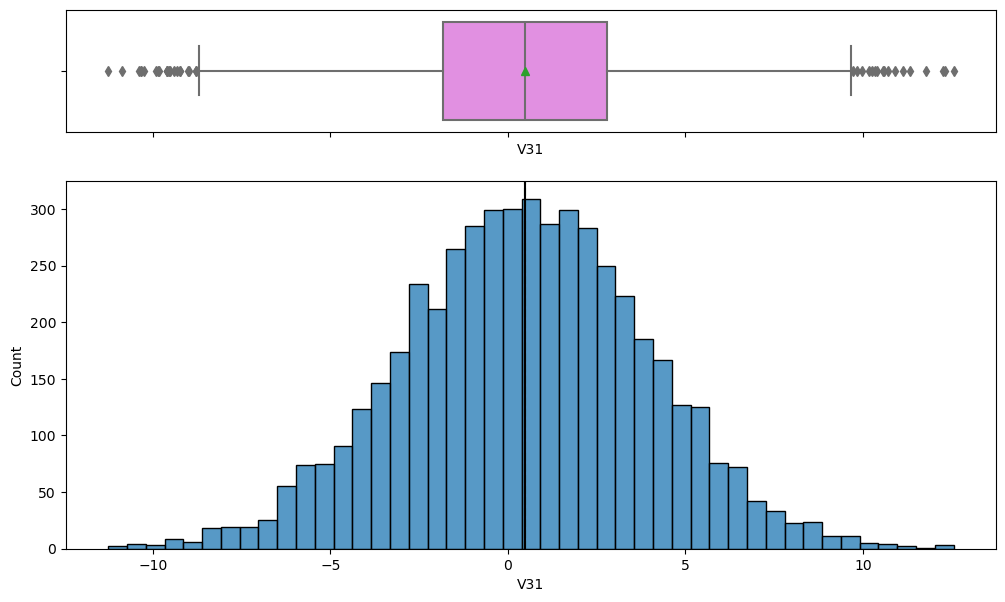

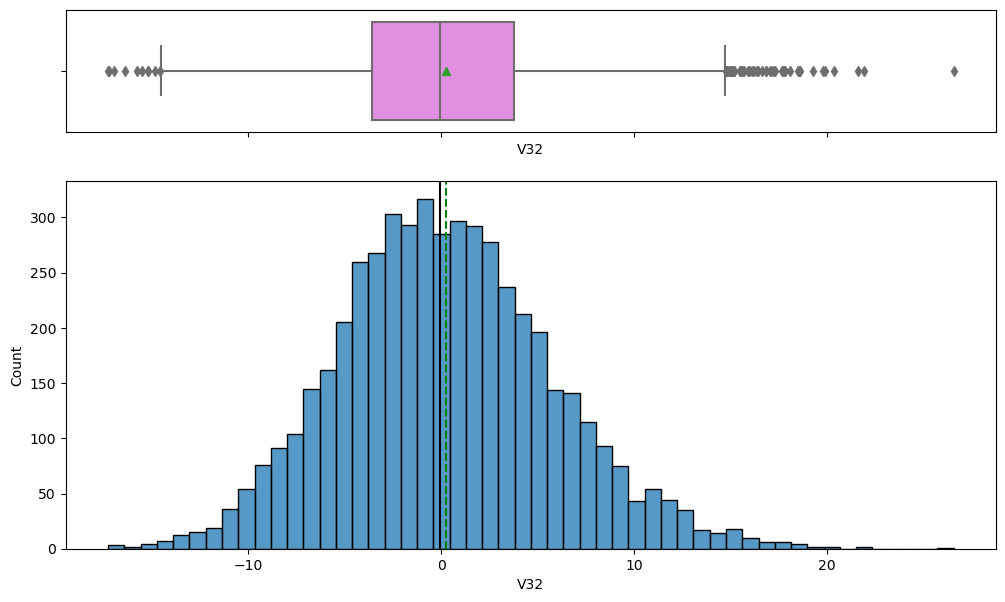

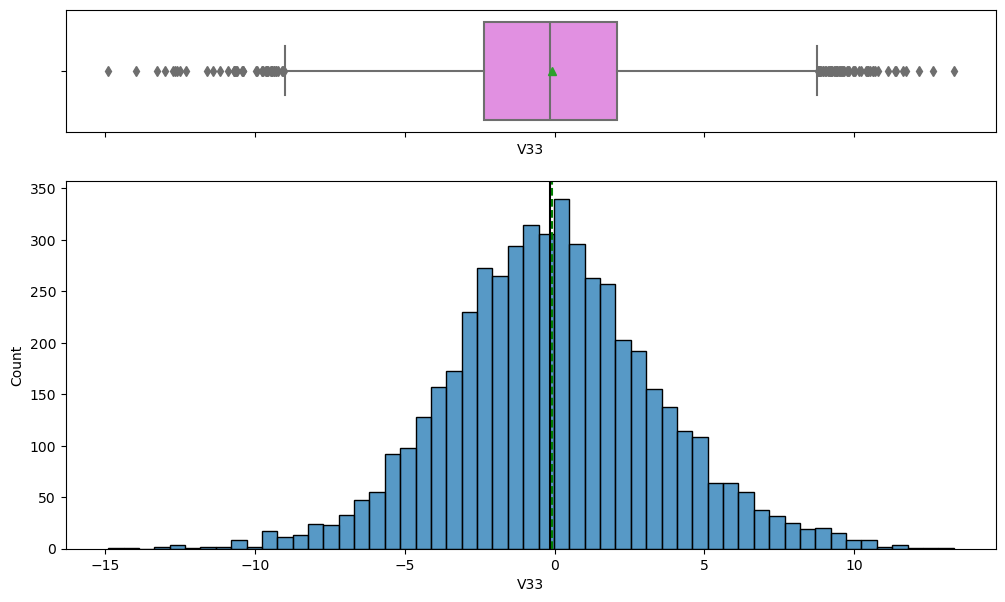

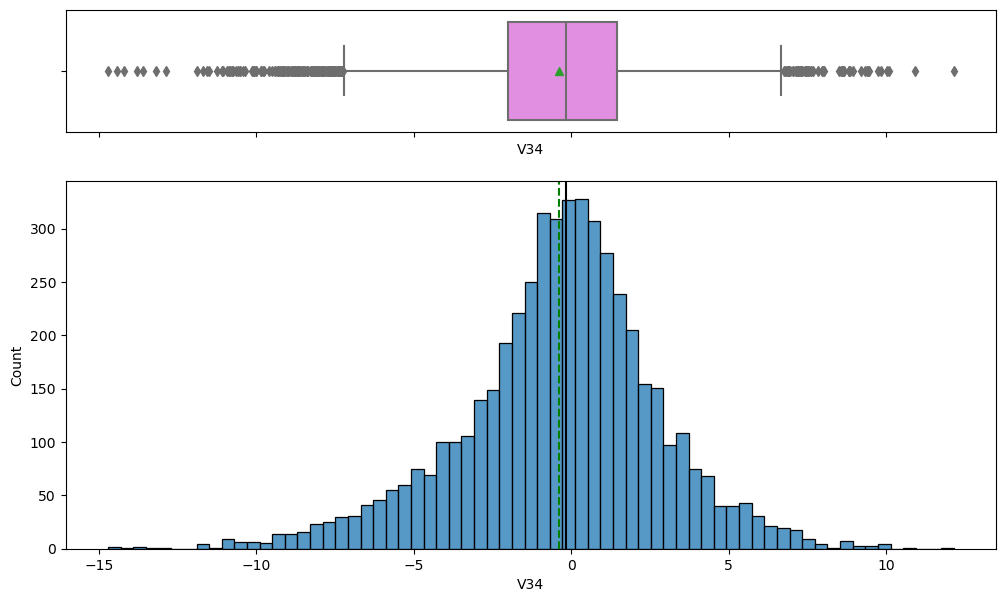

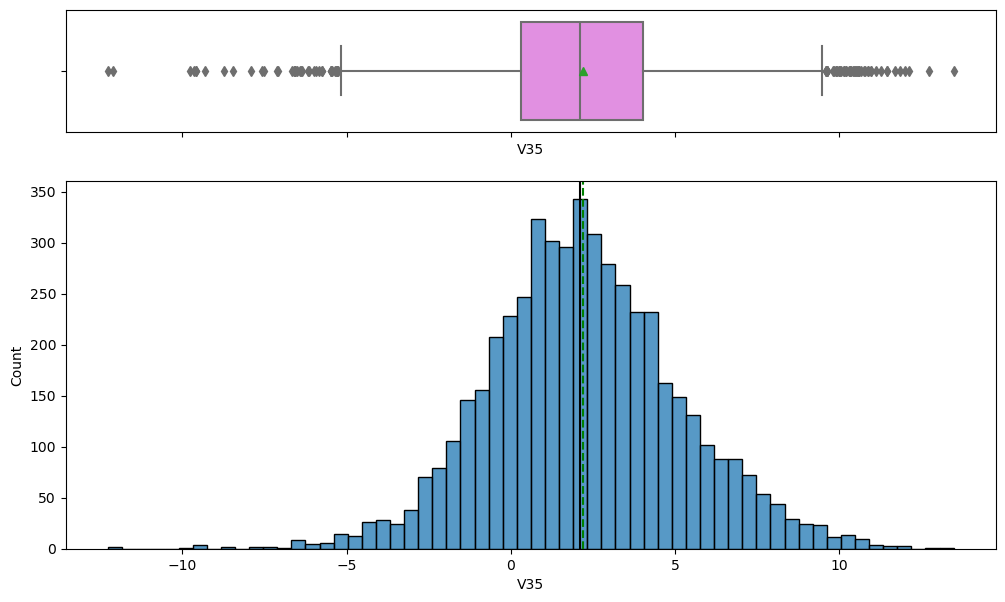

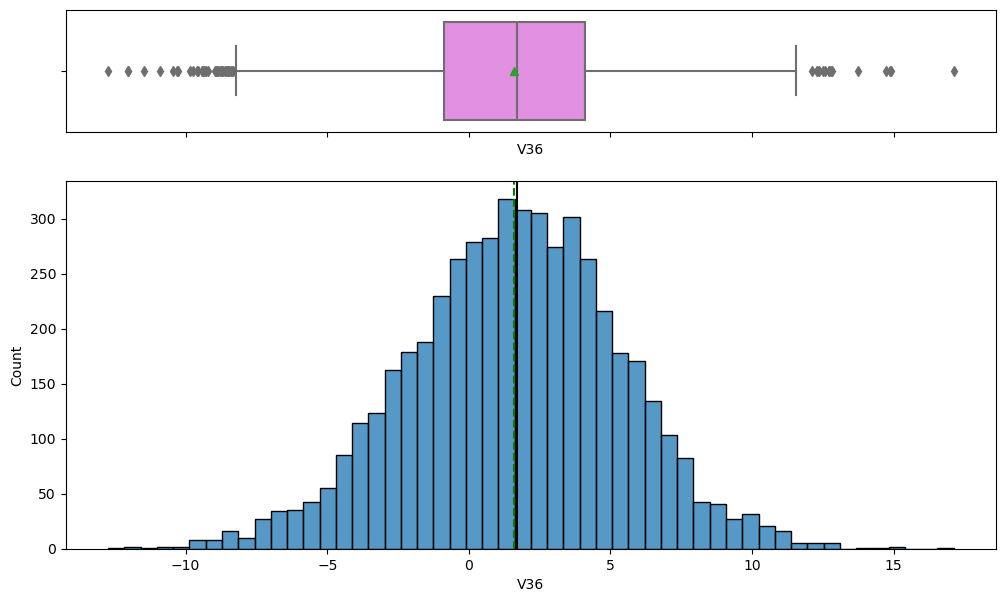

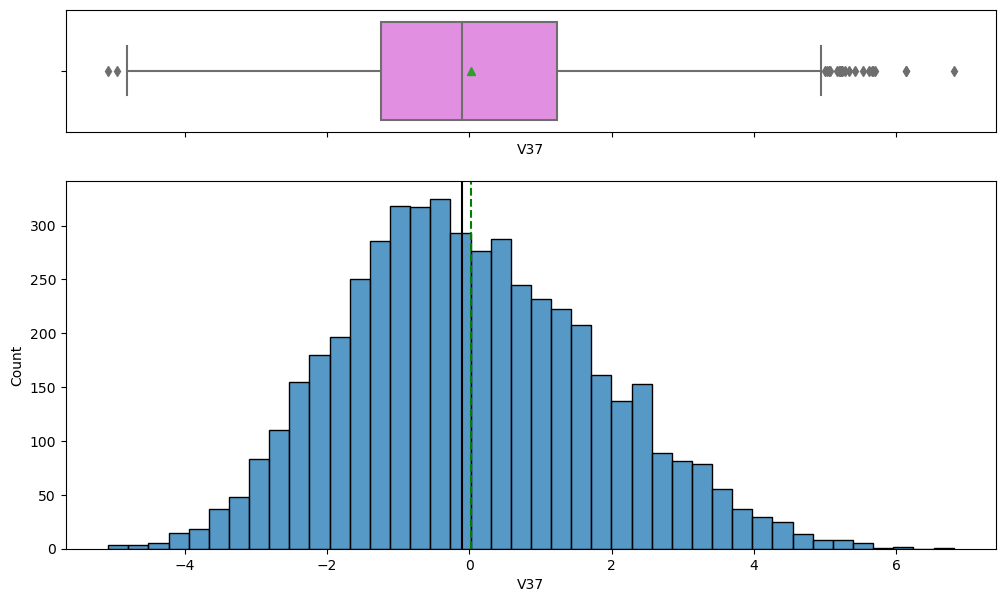

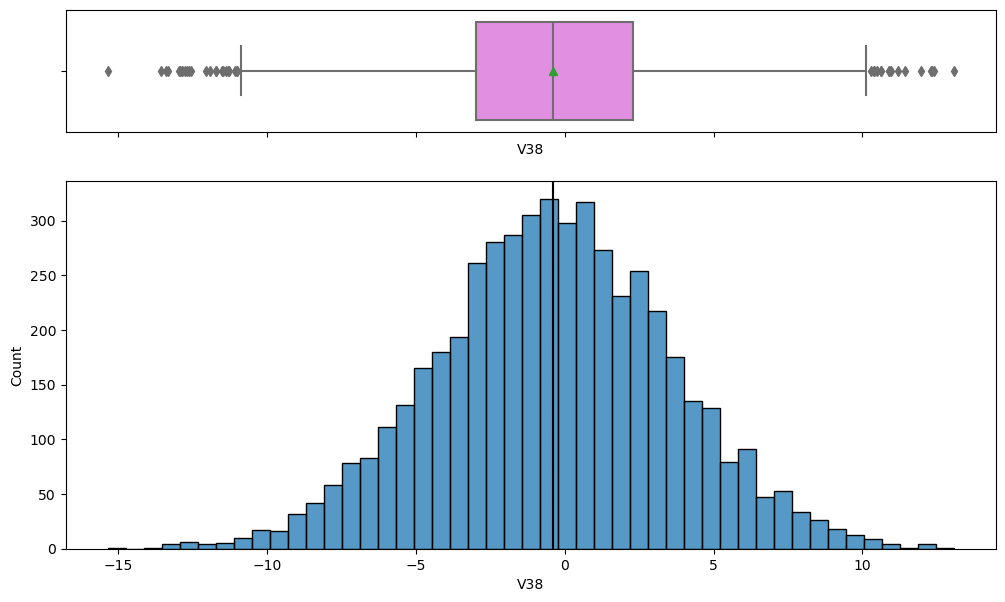

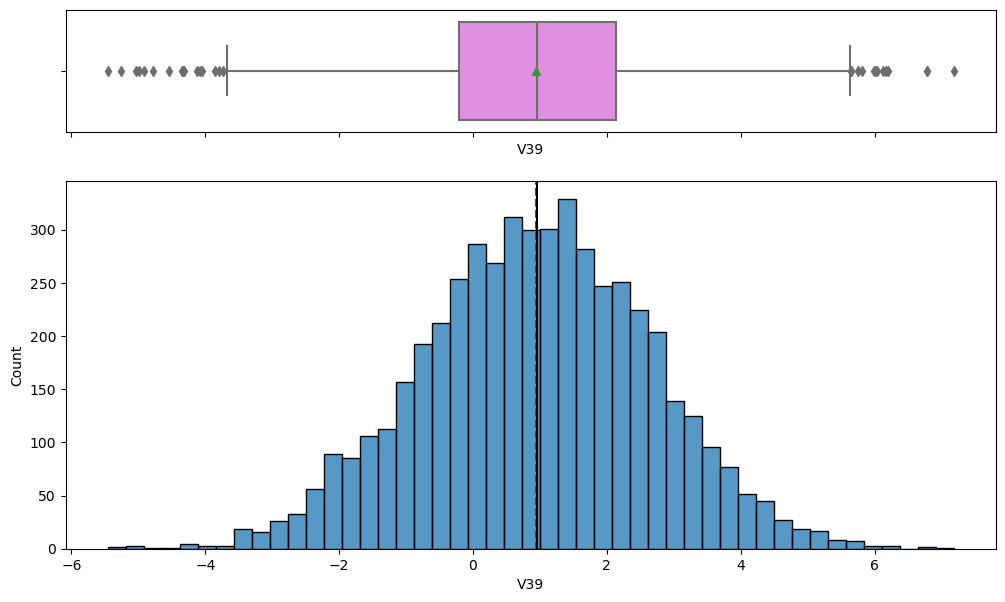

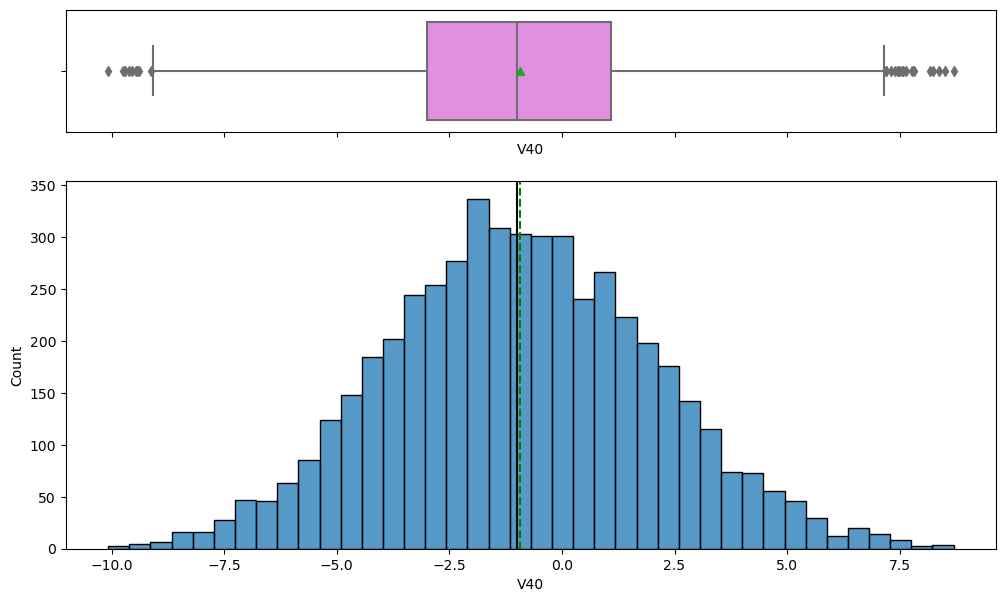

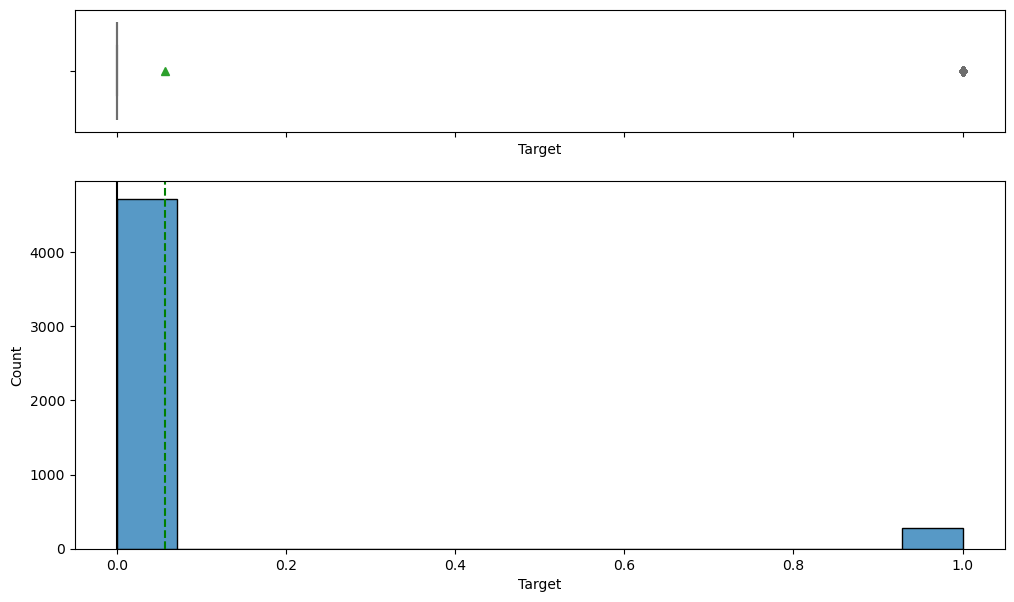

In [ ]:
for feature in df.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

* All the variables are normally distributed

### Let's look at the values in target variable

In [ ]:
data["Target"].value_counts()

Target
0    18890
1     1110
Name: count, dtype: int64

In [ ]:
data_test["Target"].value_counts()

Target
0    4718
1     282
Name: count, dtype: int64

## Data Pre-Processing

In [ ]:
X = data.drop(["Target"], axis=1)
y = data["Target"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1,stratify=y)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(15000, 40)
(5000, 40)


In [ ]:
X_test = data_test.drop(["Target"], axis=1)
y_test = data_test["Target"]

In [ ]:
X_test.shape

(5000, 40)

## Missing value imputation




In [ ]:
imputer = SimpleImputer(strategy="median")

In [ ]:
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns) ## Complete the code to impute missing values in X_val without data leakage
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns) ## Complete the code to impute missing values in X_test without data leakage

In [ ]:
print(X_train.isna().sum())
print("----------")
print(X_val.isna().sum())
print("----------")
print(X_test.isna().sum())
print("----------")

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
----------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
----------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    

* No missing values in test,train, validation data.

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator that where not predicted by model.
- False positives (FP) are failure detections in a generator where there is no failure.

The importat metric will be the one that help in predictig the TP corectly and reducing FN, so Recall should be increased.


In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

In [ ]:
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building on original data

In [ ]:
models = []

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []
names = []

print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
dtree: 0.6982829521679532
Xgboost: 0.8100497799581561

Validation Performance:

Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
dtree: 0.7050359712230215
Xgboost: 0.8309352517985612


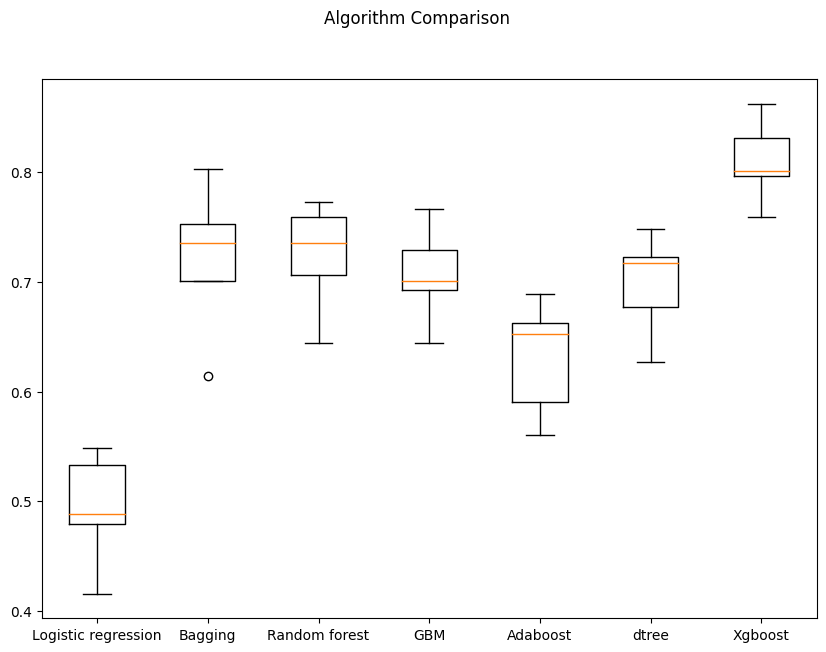

In [ ]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Recall value is highest for Xgboost followed by Bagging Classifier,Random Forest, and Gradient Boosting Classifier.

### Model Building with oversampled data

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



In [ ]:
models = []  # Empty list to store all the models

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []
names = []

print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X= X_train_over, y= y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over,y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.883963699328486
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
dtree: 0.9720494245534969
Xgboost: 0.9891305241357218

Validation Performance:

Logistic regression: 0.8489208633093526
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
dtree: 0.7769784172661871
Xgboost: 0.8669064748201439


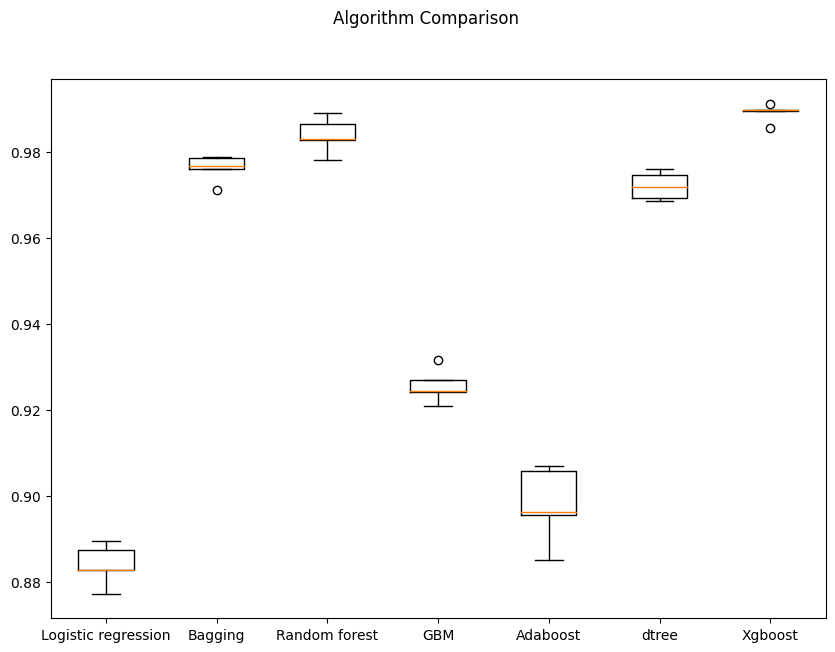

In [ ]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

- Recall value is highest for Xgboost, Random Forest, Bagging Classifier and Decision tree, but they are overfitting.

### Model Building with undersampled data

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After UnderSampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



In [ ]:
models = []

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []
names = []

print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X= X_train_un, y= y_train_un, scoring=scorer, cv=kfold, n_jobs =-1
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un,y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
GBM: 0.8990621167303946
Adaboost: 0.8666113556020489
dtree: 0.8617776495202367
Xgboost: 0.9014717552846114

Validation Performance:

Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
dtree: 0.841726618705036
Xgboost: 0.89568345323741


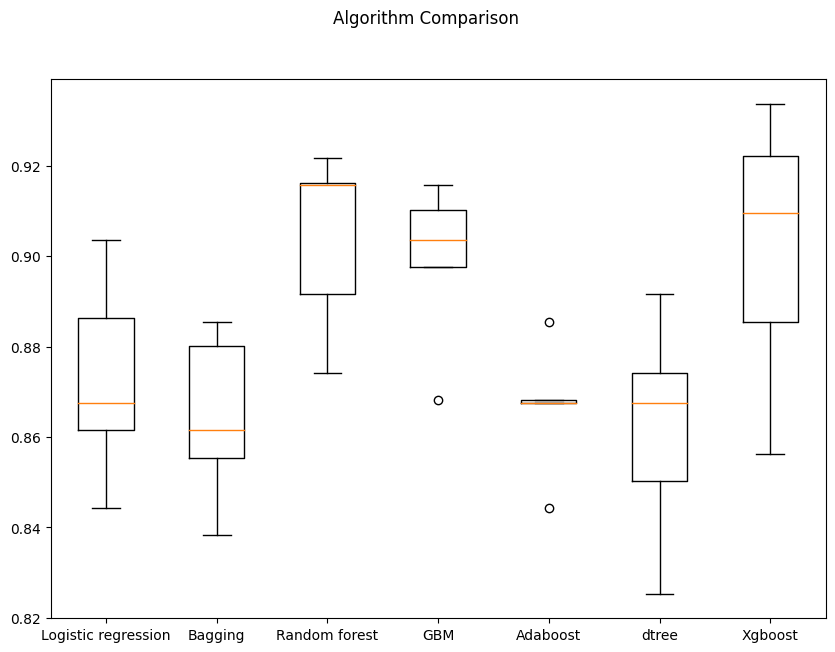

In [ ]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

* Recall value is highest for Xgboost model, Random Forest followed by Xgboost model and Gradient Boosting .

**After looking at performance of all the models, models that can further improve with hyperparameter tuning :**

- Recall value is highest for the following models:
  - Gradient Boosting with oversampled data
  - AdaBoost on oversampled data
  - Xgboost on oversampled data
  - Random Forest with undersampled data
  - Gradient Boosting  on undersampled data


## Hyperparameter Tuning

# Tuning Adaboost using oversampled data:

In [ ]:
%%time

Model = AdaBoostClassifier(random_state=1)

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)


randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))


Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:
CPU times: user 2min 29s, sys: 6.85 s, total: 2min 36s
Wall time: 58min 55s


In [ ]:
tuned_ada_over = AdaBoostClassifier(
    n_estimators= 200, learning_rate= 0.2, base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1)
)
tuned_ada_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [ ]:
tuned_ada_over_train_perf = model_performance_classification_sklearn(tuned_ada_over, X_train_over, y_train_over)
tuned_ada_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [ ]:
tuned_ada_over_val_perf = model_performance_classification_sklearn(tuned_ada_over, X_val, y_val)
tuned_ada_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


* AdaBoost is slightly overfitting the train.

# Tuning Gradient Boosting using oversampled data:

In [ ]:
%%time
Model = GradientBoostingClassifier(random_state=1)

param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:
CPU times: user 37.6 s, sys: 5.41 s, total: 43.1 s
Wall time: 27min 57s


In [ ]:
tuned_gbm_over = GradientBoostingClassifier(
    max_features=0.7,
    random_state=1,
    learning_rate=1,
    n_estimators=125,
    subsample=0.7,
)
tuned_gbm_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.7, n_estimators=125,
                           random_state=1, subsample=0.7)

In [ ]:
tuned_gbm_over_train_perf = model_performance_classification_sklearn(tuned_gbm_over, X_train_over, y_train_over)
tuned_gbm_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.993,0.993,0.993,0.993


In [ ]:
tuned_gbm_over_val_perf = model_performance_classification_sklearn(tuned_gbm_over, X_val, y_val)
tuned_gbm_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.962,0.853,0.617,0.716


* Tuned Gradient boosting using oversampled data is overfitiing on train data and not genelazing the results on validation data.


# Tuning XGBoost using oversampled data:

In [ ]:
%%time
Model = XGBClassifier(random_state=1,eval_metric='logloss')
param_grid={'n_estimators':[150,200,250],'scale_pos_weight':[5,10], 'learning_rate':[0.1,0.2], 'gamma':[0,3,5], 'subsample':[0.8,0.9]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 0} with CV score=0.9960475154078072:
CPU times: user 15.1 s, sys: 1.68 s, total: 16.7 s
Wall time: 9min 5s


In [ ]:
tuned_xgb_over = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=10,
    n_estimators=200,
    learning_rate=0.1,
    gamma=0,
)

tuned_xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [ ]:
tuned_xgb_over_train_perf = model_performance_classification_sklearn(tuned_xgb_over, X_train_over, y_train_over)
tuned_xgb_over_train_perf

,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.997,0.998


In [ ]:
tuned_xgb_over_val_perf =model_performance_classification_sklearn(tuned_xgb_over, X_val, y_val)
tuned_xgb_over_val_perf

,Accuracy,Recall,Precision,F1
0,0.978,0.885,0.764,0.820


* Tuned XG boost using oversampled data is overfitiing on train data and not genelazing the results on validation data.

# Tuning Random forest using undersampled data:

In [ ]:
%%time
Model = RandomForestClassifier(random_state=1)
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:
CPU times: user 3.59 s, sys: 259 ms, total: 3.85 s
Wall time: 2min 18s


In [ ]:
tuned_rf_under = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2,
)
tuned_rf_under.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [ ]:
tuned_rf_under_train_perf = model_performance_classification_sklearn(tuned_rf_under, X_train_un, y_train_un)
tuned_rf_under_train_perf

,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [ ]:
tuned_rf_under_val_perf = model_performance_classification_sklearn(tuned_rf_under, X_val, y_val)
tuned_rf_under_val_perf

,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


* Tuned Random forest using undersampled data is slightly overfitiing on train data compared to the other model, the results on validation data for accuracy and recall are close to train data.


# Tuning Gradient Boosting using undersampling data:

In [ ]:
%%time

Model = GradientBoostingClassifier(random_state=1)

param_grid={"n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7]}

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

randomized_cv.fit(X_train_un, y_train_un)
print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9014212538777866:
CPU times: user 2.21 s, sys: 153 ms, total: 2.36 s
Wall time: 1min 37s


In [ ]:
tuned_gbm_under = GradientBoostingClassifier(
    max_features=0.5,
    learning_rate=0.2,
    n_estimators=100,
    subsample=0.7,
)
tuned_gbm_under.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5, subsample=0.7)

In [ ]:
tuned_gbm_under_train_perf = model_performance_classification_sklearn(tuned_gbm_under, X_train_un, y_train_un)
tuned_gbm_under_train_perf

,Accuracy,Recall,Precision,F1
0,0.989,0.981,0.996,0.988


In [ ]:
tuned_gbm_under_val_perf = model_performance_classification_sklearn(tuned_gbm_under, X_val, y_val)
tuned_gbm_under_val_perf

,Accuracy,Recall,Precision,F1
0,0.930,0.896,0.435,0.586


* Tuned Gradient boosting using undersampled data is overfitiing on train data and is not generalizing with validation data.

## Model performance comparison and choosing the final model

In [ ]:
models_train_comp_df = pd.concat(
    [

        tuned_ada_over_train_perf.T,
        tuned_gbm_over_train_perf.T,
        tuned_xgb_over_train_perf.T,
        tuned_rf_under_train_perf.T,
        tuned_gbm_under_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [

    "AdaBoost classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient Boosting tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,AdaBoost classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,XGBoost tuned with oversampled data,Random forest tuned with undersampled data,Gradient Boosting tuned with undersampled data
Accuracy,0.992,0.993,0.998,0.961,0.989
Recall,0.988,0.993,1.000,0.933,0.981
Precision,0.995,0.993,0.997,0.989,0.996
F1,0.992,0.993,0.998,0.960,0.988


In [ ]:
models_val_comp_df = pd.concat(
    [
        tuned_ada_over_val_perf.T,
        tuned_gbm_over_val_perf.T,
        tuned_xgb_over_val_perf.T,
        tuned_rf_under_val_perf.T,
        tuned_gbm_under_val_perf.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [

    "AdaBoost classifier tuned with oversampled data",
    "Gradient Boosting tuned with oversampled data",
    "XGBoost tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient Boosting tuned with undersampled data",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,AdaBoost classifier tuned with oversampled data,Gradient Boosting tuned with oversampled data,XGBoost tuned with oversampled data,Random forest tuned with undersampled data,Gradient Boosting tuned with undersampled data
Accuracy,0.979,0.962,0.978,0.938,0.930
Recall,0.853,0.853,0.885,0.885,0.896
Precision,0.790,0.617,0.764,0.468,0.435
F1,0.820,0.716,0.820,0.612,0.586


- The best validation recall score is 89.6% and obtained for Gradient boosting tuned with undersampled data followed by recall score of 88.5% and obtained for tuned Randomforest with undersampled data.
- But the validation precision for both is very low which will result in increased inspection cost.
-  Tuned XGboost with overrsampled data gives the ext higher recall of 88.5%  however its overfitting the trai data.
- So, AdaBoost tuned with oversampled data will be chosen as the final model whereit gives 85% recall and its not overfitting the train data.

# Test set final performance

In [ ]:
ada_test = model_performance_classification_sklearn(tuned_ada_over, X_test, y_test)
ada_test

,Accuracy,Recall,Precision,F1
0,0.978,0.844,0.780,0.811


### Feature Importances

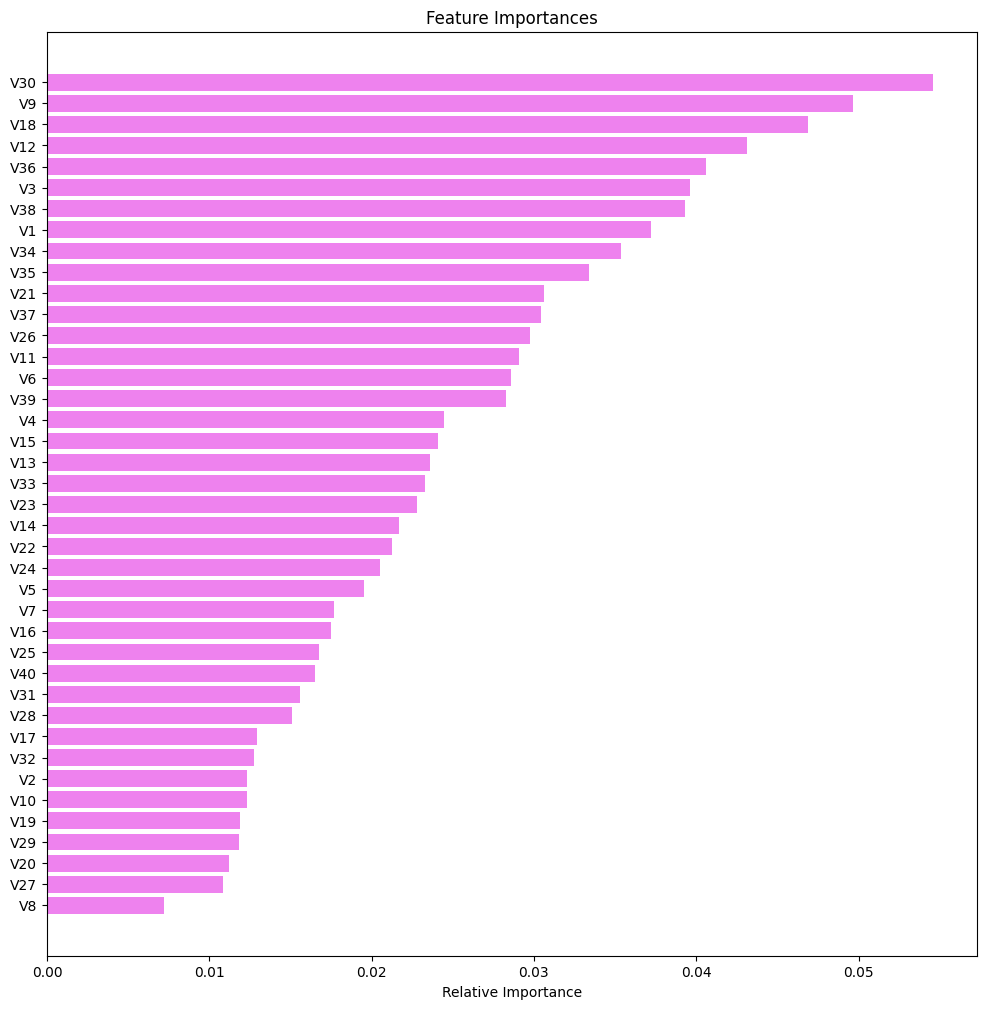

In [ ]:
feature_names = X_train.columns
importances = tuned_ada_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- V30 is most important feature followed by V9 and V18.

# Pipelines to build the final model

In [ ]:
Pipeline_model = Pipeline(
   steps=[
        ("imputer", SimpleImputer(strategy="median")),
        (
            "AdaBoost Classifier",
             AdaBoostClassifier(
                random_state=1,
                learning_rate=0.2,
                n_estimators=200,
                base_estimator= DecisionTreeClassifier(max_depth=3, random_state=1),
            ),
       ),
    ]
)

In [ ]:
X_train1 = data.drop(columns="Target")
Y_train1 = data["Target"]

X_test1 = data_test.drop(columns="Target")
y_test1 = data_test["Target"]


In [ ]:
imputer = SimpleImputer(strategy="median")
X_train1 = imputer.fit_transform(X_train1)

In [ ]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train1, Y_train1)

In [ ]:
Pipeline_model.fit(X_train_over, y_train_over)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('AdaBoost Classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                                          random_state=1),
                                    learning_rate=0.2, n_estimators=200,
                                    random_state=1))])

In [ ]:
Pipeline_model_test = model_performance_classification_sklearn(Pipeline_model, X_test1, y_test1)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.978,0.851,0.774,0.811


# Business Insights and Conclusions



- The AdaBoost Classifier tuned using oversampled data has the best performance.
- V30, V9 and V18 are the most important features. They can be deciphered to determine and analyze the actual variables to understand their impact on the predictive task at hand.
- This model can be further used to detect if a wind turbine will fail or not and this will help reduce the cost.

***